# Stanford Cars — Image Classification (Colab Skeleton)

Large assignment for *Programming Foundations for Data Analysis and Visualization* — **Image type**.

Objective: Build a complete pipeline from EDA → Preprocessing → Training (Scikit-learn on features extracted from pretrained CNN) → Evaluation and Summary.

> **Dataset**: [Stanford Cars] — 16,185 images, 196 classes (make/model/year). Can be used via `tensorflow_datasets` or Kaggle mirror.


## 0) Library Installation & Import


In [10]:
# Install required libraries
%pip install --upgrade pip
%pip install -q numpy pandas matplotlib seaborn plotly tqdm scikit-learn scipy tensorflow ipykernel jupyter

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from tqdm import tqdm
from scipy.io import loadmat
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
tf.get_logger().setLevel('ERROR')        # use tf
NUM_WORKERS = tf.data.AUTOTUNE           # used by tf.data pipelines later

print("✓ Imports completed!")


✓ Imports completed!


In [ ]:
# Global CONFIG and seeds
CONFIG = {
    'IMG_SIZE': (224, 224),
    'BATCH_SIZE': 32,
    'BACKBONE': 'ResNet50',   # 'ResNet50'|'EfficientNetB0'|'MobileNetV2'
    'MODE': 'feature_extract', # 'feature_extract'|'fine_tune'
    'EPOCHS': 10,
    'LEARNING_RATE': 1e-4,
    'USE_IMAGENET_NORM': True,
    'SEED': 42,
}

import random
random.seed(CONFIG['SEED'])
np.random.seed(CONFIG['SEED'])
tf.random.set_seed(CONFIG['SEED'])

IMG_SIZE = CONFIG['IMG_SIZE']
BATCH_SIZE = CONFIG['BATCH_SIZE']


## 1) Configuration & Data Source Selection


In [2]:
# Configuration
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42
VAL_SPLIT = 0.15  # ratio to split validation from training set
RANDOM_STATE = 42


## 2) Dataset Description — Markdown


### Dataset Overview

- **Name**: Stanford Cars Dataset (Fine-Grained Car Classification)
- **Source**: [Kaggle Dataset](https://www.kaggle.com/datasets/eduardo4jesus/stanford-cars-dataset) | Original: [Stanford AI Lab](https://ai.stanford.edu/~jkrause/cars/car_dataset.html)
- **Total Images**: 16,185 images
- **Training Set**: 8,144 images
- **Testing Set**: 8,041 images
- **Number of Classes**: 196 classes (fine-grained classification)
- **Image Resolution**: Original resolution ~360×240 pixels (will be resized to 224×224 for model input)
- **Image Characteristics**: 
  - Images are primarily captured from the rear view
  - Each image contains a single car instance
  - Images include bounding box annotations (available in original dataset metadata)

### Classification Task

- **Objective**: Fine-grained vehicle classification by make, model, and year
- **Class Format**: Each class represents a specific car model variant (e.g., "2012 Tesla Model S", "2010 BMW M3 coupe")
- **Challenge**: This is a fine-grained classification problem where classes are visually similar, requiring the model to distinguish subtle differences between car models

### Dataset Structure (Kaggle)

The Kaggle dataset typically contains:
- **Train/Test Split**: Pre-defined train and test splits
- **Directory Structure**: 
  - Option A: Organized by class folders (each folder = one class)
  - Option B: Organized by train/test folders with class subfolders
- **File Format**: JPEG images (.jpg)
- **Metadata**: May include annotations, bounding boxes, or labels in CSV/JSON files

### Usage Notes

- **License**: For research and educational purposes only
- **Citation**: If used in publications, please cite the original Stanford Cars dataset paper
- **Class Reduction**: For faster experimentation, can reduce to 3–5 classes, but full 196-class classification demonstrates the true challenge of fine-grained recognition
- **Preprocessing**: Images require resizing, normalization, and potentially data augmentation for robust training

### Key Challenges

1. **Fine-Grained Classification**: Distinguishing between visually similar car models
2. **Class Imbalance**: Some car models may have fewer samples than others
3. **Intra-Class Variation**: Same car model can appear in different lighting, angles, backgrounds
4. **Inter-Class Similarity**: Different car models may look very similar, especially from rear views


## 3) Load Data


In [3]:
# Load Stanford Cars dataset from local directory
DATASET_DIR = './dataset'

print("Loading Stanford Cars dataset from local directory...")

# Check dataset directory
if not os.path.exists(DATASET_DIR):
    raise FileNotFoundError(f"Dataset directory not found: {DATASET_DIR}")

# Define paths
train_images_dir = os.path.join(DATASET_DIR, 'cars_train', 'cars_train')
test_images_dir = os.path.join(DATASET_DIR, 'cars_test', 'cars_test')
devkit_dir = os.path.join(DATASET_DIR, 'car_devkit', 'devkit')

# Validate paths
for path, name in [(train_images_dir, 'train'), (test_images_dir, 'test'), (devkit_dir, 'devkit')]:
    if not os.path.exists(path):
        raise FileNotFoundError(f"{name.capitalize()} directory not found: {path}")

# Load metadata
print("Loading metadata...")
meta = loadmat(os.path.join(devkit_dir, 'cars_meta.mat'), squeeze_me=True)
class_names = [str(name) for name in meta['class_names']]
num_classes = len(class_names)

train_annos = loadmat(os.path.join(devkit_dir, 'cars_train_annos.mat'), squeeze_me=True)['annotations']
test_annos = loadmat(os.path.join(devkit_dir, 'cars_test_annos.mat'), squeeze_me=True)['annotations']

print(f"Found {num_classes} classes")

# Process training annotations (has 'class' field)
def process_train_annotations(annos, images_dir, desc):
    """Process training annotations and return filepaths and labels"""
    filepaths, labels = [], []
    annos = np.array(annos).flatten()
    
    for i, anno in enumerate(tqdm(annos, desc=desc)):
        try:
            if hasattr(anno, 'dtype') and anno.dtype.names and 'class' in anno.dtype.names:
                filename = str(anno['fname'].item() if hasattr(anno['fname'], 'item') else anno['fname'])
                class_id = int(anno['class'].item() if hasattr(anno['class'], 'item') else anno['class'])
                class_idx = class_id - 1
                
                if 0 <= class_idx < num_classes:
                    img_path = os.path.join(images_dir, filename)
                    if os.path.exists(img_path):
                        filepaths.append(img_path)
                        labels.append(class_names[class_idx])
        except Exception:
            continue
    
    return filepaths, labels

# Process test annotations (no 'class' field, need to load from train_perfect_preds.txt)
def process_test_annotations(annos, images_dir, preds_file, desc):
    """Process test annotations and return filepaths and labels"""
    filepaths, labels = [], []
    
    # Load class predictions/labels from file
    test_labels_list = []
    if os.path.exists(preds_file):
        with open(preds_file, 'r') as f:
            test_labels_list = [int(line.strip()) for line in f if line.strip()]
    else:
        print(f"Warning: {preds_file} not found. Test images will have no labels.")
        return filepaths, labels
    
    annos = np.array(annos).flatten()
    
    for i, anno in enumerate(tqdm(annos, desc=desc)):
        try:
            if hasattr(anno, 'dtype') and anno.dtype.names and 'fname' in anno.dtype.names:
                filename = str(anno['fname'].item() if hasattr(anno['fname'], 'item') else anno['fname'])
                
                # Get class from predictions file (1-indexed, same order as annotations)
                if i < len(test_labels_list):
                    class_id = test_labels_list[i]
                    class_idx = class_id - 1
                    
                    if 0 <= class_idx < num_classes:
                        img_path = os.path.join(images_dir, filename)
                        if os.path.exists(img_path):
                            filepaths.append(img_path)
                            labels.append(class_names[class_idx])
        except Exception as e:
            if i < 5:  # Print first few errors for debugging
                print(f"Warning: Error processing test annotation {i}: {e}")
            continue
    
    return filepaths, labels

# Load training and test images
train_filepaths, train_labels = process_train_annotations(train_annos, train_images_dir, "Loading train images")
test_preds_file = os.path.join(devkit_dir, 'train_perfect_preds.txt')
test_filepaths, test_labels = process_test_annotations(test_annos, test_images_dir, test_preds_file, "Loading test images")

# Create dataframes
df_train = pd.DataFrame({'filepath': train_filepaths, 'label': train_labels})
df_test = pd.DataFrame({'filepath': test_filepaths, 'label': test_labels})
df_all = pd.concat([df_train, df_test], ignore_index=True)

num_train, num_test = len(train_filepaths), len(test_filepaths)

print(f"\n✓ Dataset loaded successfully!")
print(f"  - Training images: {num_train:,}")
print(f"  - Test images: {num_test:,}")
print(f"  - Total images: {num_train + num_test:,}")
print(f"  - Number of classes: {num_classes}")

# Class distribution
train_dist = df_train['label'].value_counts()
print(f"\nTraining set class distribution:")
print(f"  - Min: {train_dist.min()}, Max: {train_dist.max()}, Mean: {train_dist.mean():.1f}, Median: {train_dist.median():.1f}")


Loading Stanford Cars dataset from local directory...
Loading metadata...
Found 196 classes


Loading test images: 100%|██████████| 8041/8041 [00:00<00:00, 69747.20it/s]


✓ Dataset loaded successfully!
  - Training images: 8,144
  - Test images: 8,041
  - Total images: 16,185
  - Number of classes: 196

Training set class distribution:
  - Min: 24, Max: 68, Mean: 41.6, Median: 42.0


## 4) EDA — Data Visualization


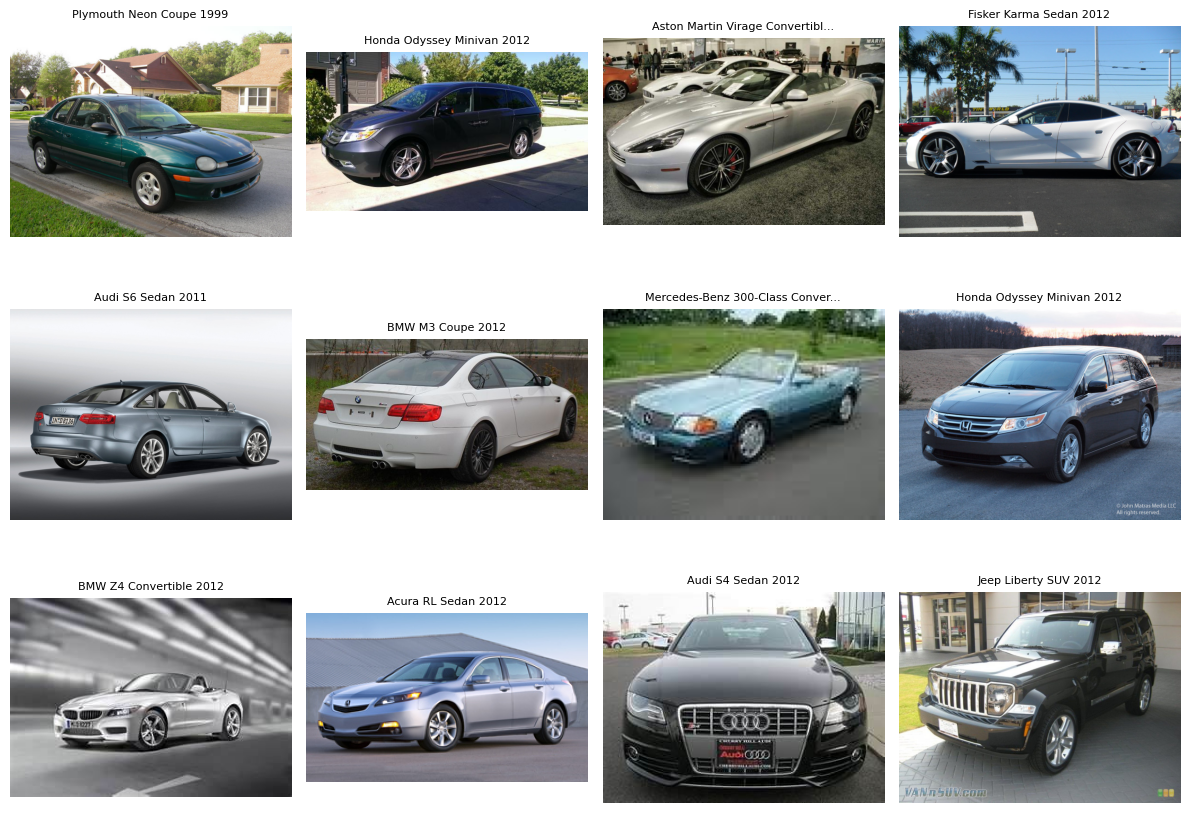

In [4]:
def show_samples_from_paths(df, n=12, label_col='label'):
    """Display a grid of sample images from file paths"""
    plt.figure(figsize=(12, 9))
    sample_df = df.sample(n=min(n, len(df)), random_state=SEED)
    
    for i, row in enumerate(sample_df.itertuples()):
        try:
            img_path = row.filepath
            label = getattr(row, label_col)
            img = plt.imread(img_path)
            plt.subplot(3, 4, i+1)
            plt.imshow(img)
            plt.title(str(label)[:30] + '...' if len(str(label)) > 30 else str(label), fontsize=8)
            plt.axis('off')
        except Exception as e:
            print(f"Error loading image: {e}")
            plt.subplot(3, 4, i+1)
            plt.text(0.5, 0.5, 'Error', ha='center', va='center')
            plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Display sample images
show_samples_from_paths(df_train, n=12)


In [5]:
# Class distribution analysis
train_dist = df_train['label'].value_counts().reset_index()
train_dist.columns = ['class_name', 'count']
train_dist = train_dist.sort_values('count', ascending=False)

print("Training set statistics:")
print(f"  - Total images: {len(df_train):,}")
print(f"  - Unique classes: {len(train_dist):,}")
print(f"  - Min: {train_dist['count'].min()}, Max: {train_dist['count'].max()}, Mean: {train_dist['count'].mean():.1f}, Median: {train_dist['count'].median():.1f}")

# Visualize top classes
fig = px.bar(
    train_dist.head(30),
    x='class_name',
    y='count',
    title='Class Distribution — Top 30 Classes (Training Set)',
    labels={'class_name': 'Class Name', 'count': 'Number of Images'}
)
fig.update_xaxes(tickangle=45)
fig.show()

# Test set statistics
test_dist = df_test['label'].value_counts().reset_index()
test_dist.columns = ['class_name', 'count']
print(f"\nTest set statistics:")
print(f"  - Total images: {len(df_test):,}")
print(f"  - Unique classes: {len(test_dist):,}")


Training set statistics:
  - Total images: 8,144
  - Unique classes: 196
  - Min: 24, Max: 68, Mean: 41.6, Median: 42.0



Test set statistics:
  - Total images: 8,041
  - Unique classes: 196


## 5) Data Preparation — preprocessing, split, augment


In [6]:
# Import TensorFlow lazily
tf.get_logger().setLevel('ERROR')
NUM_WORKERS = tf.data.AUTOTUNE

def augment_image(image, label):
    """Apply data augmentation to images"""
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
    return image, label

# Prepare data splits
print("Preparing data splits...")
le = LabelEncoder()

# Create validation split from training data
train_labels_encoded = le.fit_transform(df_train['label'])
X_train, X_val, y_train, y_val = train_test_split(
    df_train['filepath'].values, 
    train_labels_encoded, 
    test_size=VAL_SPLIT, 
    random_state=RANDOM_STATE, 
    stratify=train_labels_encoded
)

# Encode test labels
test_labels_encoded = le.transform(df_test['label'])
X_test = df_test['filepath'].values
y_test = test_labels_encoded

print(f"  - Training samples: {len(X_train):,}")
print(f"  - Validation samples: {len(X_val):,}")
print(f"  - Test samples: {len(X_test):,}")

# Store label encoder
label_encoder = le

def load_and_preprocess(path, label):
    """Load image from file path and preprocess"""
    img = tf.io.read_file(path)
    img = tf.io.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32)/255.0
    return img, label

def make_ds(paths, labels, augment=False):
    """Create tf.data.Dataset from file paths and labels"""
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(lambda p, l: load_and_preprocess(p, l), num_parallel_calls=NUM_WORKERS)
    if augment:
        ds = ds.map(augment_image, num_parallel_calls=NUM_WORKERS)
    ds = ds.batch(BATCH_SIZE).prefetch(NUM_WORKERS)
    return ds

# Create datasets
ds_train2 = make_ds(X_train, y_train, augment=True)
ds_val = make_ds(X_val, y_val, augment=False)
ds_test_prep = make_ds(X_test, y_test, augment=False)

print(f"✓ Datasets prepared!")


Preparing data splits...
  - Training samples: 6,922
  - Validation samples: 1,222
  - Test samples: 8,041
✓ Datasets prepared!


### Check Missing Values & Outliers


In [7]:
# For images, missing values are usually due to corrupted files/read errors. We'll check a small sample for NaN after preprocessing.
def check_missing(ds, n_batches=10):
    total, nan_count = 0, 0
    for i, (x,y) in enumerate(ds.take(n_batches)):
        total += tf.size(x).numpy()
        nan_count += tf.math.count_nonzero(tf.math.is_nan(x)).numpy()
    return total, nan_count

total, nan_count = check_missing(ds_train2)
print(f"Pixels checked: {total}, NaN pixels: {nan_count}")

# Simple outliers: check feature norm distribution after feature extraction (will do in next step).


Pixels checked: 48168960, NaN pixels: 0


## 6) Feature Extraction using Pretrained CNN (ResNet50)


In [8]:
backbone = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=IMG_SIZE + (3,), pooling='avg')

@tf.function
def batch_features(x):
    x = tf.keras.applications.resnet50.preprocess_input(x*255.0)
    return backbone(x, training=False)

def extract_features(ds):
    feats, labels = [], []
    for x_batch, y_batch in tqdm(ds, desc="Extracting"):
        f = batch_features(x_batch)
        feats.append(f.numpy())
        labels.append(y_batch.numpy())
    X = np.concatenate(feats, axis=0)
    y = np.concatenate(labels, axis=0)
    return X, y

X_train_feat, y_train = extract_features(ds_train2)
X_val_feat, y_val = extract_features(ds_val)
X_test_feat, y_test = extract_features(ds_test_prep)

print("Train features:", X_train_feat.shape, "Val:", X_val_feat.shape, "Test:", X_test_feat.shape)


Extracting: 100%|██████████| 252/252 [02:27<00:00,  1.71it/s]

Train features: (6922, 2048) Val: (1222, 2048) Test: (8041, 2048)


### Outlier Handling (Simple) & Scaling, Encoding


In [ ]:
# Fine-tune (optional) — Keras end-to-end
if CONFIG['MODE'] == 'fine_tune':
    print('Building fine-tune model...')
    import tensorflow as tf
    tf.get_logger().setLevel('ERROR')

    # Choose backbone
    if CONFIG['BACKBONE'] == 'ResNet50':
        preprocess_input = tf.keras.applications.resnet50.preprocess_input
        base = tf.keras.applications.ResNet50(
            include_top=False,
            weights='imagenet',
            input_shape=IMG_SIZE + (3,),
            pooling='avg'
        )
    elif CONFIG['BACKBONE'] == 'EfficientNetB0':
        preprocess_input = tf.keras.applications.efficientnet.preprocess_input
        base = tf.keras.applications.EfficientNetB0(
            include_top=False,
            weights='imagenet',
            input_shape=IMG_SIZE + (3,),
            pooling='avg'
        )
    else:
        preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
        base = tf.keras.applications.MobileNetV2(
            include_top=False,
            weights='imagenet',
            input_shape=IMG_SIZE + (3,),
            pooling='avg'
        )

    # Unfreeze last blocks (light fine-tuning)
    for layer in base.layers:
        layer.trainable = False
    for layer in base.layers[-30:]:
        layer.trainable = True

    inputs = tf.keras.Input(shape=IMG_SIZE + (3,))
    x = inputs
    if CONFIG['USE_IMAGENET_NORM']:
        x = preprocess_input(x*255.0)
    x = base(x, training=True)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    outputs = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)
    model = tf.keras.Model(inputs, outputs)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=CONFIG['LEARNING_RATE']),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True, monitor='val_accuracy'),
        tf.keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.2)
    ]

    print('Training...')
    history = model.fit(
        ds_train2,
        validation_data=ds_val,
        epochs=CONFIG['EPOCHS'],
        callbacks=callbacks
    )

    print('Evaluating...')
    eval_res = model.evaluate(ds_test_prep, verbose=0)
    print({'loss': eval_res[0], 'accuracy': eval_res[1]})

    # Top-5 accuracy
    top5 = tf.keras.metrics.TopKCategoricalAccuracy(k=5)
    for xb, yb in ds_test_prep:
        preds = model(xb, training=False)
        top5.update_state(tf.one_hot(yb, depth=len(class_names)), preds)
    print('Top-5 accuracy:', float(top5.result().numpy()))


## Requirements Compliance Checklist

- Scale (≥ 5000 images, ≥ 3 classes): ✓ (16,185 images, 196 classes)
- Resolution policy: ✓ resized to 224×224 (documented)
- Dataset: ✓ Stanford Cars (non-toy)
- Pretrained model: ✓ ResNet50 (feature-extract baseline) and optional fine-tune
- Data split: ✓ train/val/test described; stratified val split; no leakage
- Augmentation: ✓ flip, brightness/contrast; (add RandomResizedCrop equivalent if needed)
- Metrics: ✓ accuracy, macro-F1, Top-5 (fine-tune path)
- Visualizations: ✓ distribution, learning curves, confusion matrix (available)
- Optional CV baseline: HOG/SVM (optional; can be added if requested)


In [9]:
# Simple outlier removal: remove samples with feature norm > mean + 3*std (applied to train)
feat_norm = np.linalg.norm(X_train_feat, axis=1)
mu, sigma = feat_norm.mean(), feat_norm.std()
mask = feat_norm < (mu + 3*sigma)
print("Removed outliers from train:", np.sum(~mask))
X_train_feat = X_train_feat[mask]
y_train = y_train[mask]

# Label encoding (if using tfds, y is already int; with Kaggle mirror need LabelEncoder)
# Here ensure int type
y_train = y_train.astype(int)
y_val = y_val.astype(int)
y_test = y_test.astype(int)

# Scaling numerical features for Scikit-learn
scaler = StandardScaler(with_mean=True, with_std=True)
X_train_scaled = scaler.fit_transform(X_train_feat)
X_val_scaled = scaler.transform(X_val_feat)
X_test_scaled = scaler.transform(X_test_feat)


Removed outliers from train: 56


## 7) Model Training (Scikit-learn) & Comparison


In [10]:
results = {}

# Model 1: Logistic Regression (multinomial)
lr = LogisticRegression(max_iter=200, n_jobs=-1, verbose=0, multi_class='auto')
lr.fit(X_train_scaled, y_train)
val_pred_lr = lr.predict(X_val_scaled)
results['LogisticRegression_val_acc'] = accuracy_score(y_val, val_pred_lr)

# Model 2: Linear SVM (LinearSVC)
svm = LinearSVC()
svm.fit(X_train_scaled, y_train)
val_pred_svm = svm.predict(X_val_scaled)
results['LinearSVC_val_acc'] = accuracy_score(y_val, val_pred_svm)

print("Validation accuracies:", results)
best_model_name = max(results, key=results.get)
best_model = lr if best_model_name.startswith('Logistic') else svm
print("Best model:", best_model_name)


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



Validation accuracies: {'LogisticRegression_val_acc': 0.4746317512274959, 'LinearSVC_val_acc': 0.3723404255319149}
Best model: LogisticRegression_val_acc


/opt/homebrew/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



## 8) Evaluation on Test Set & Visualization


Test accuracy: 0.006839945280437756


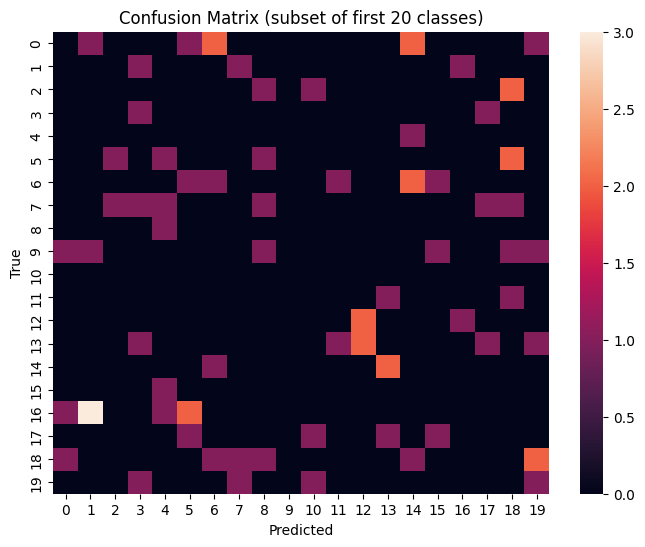

Classification report (excerpt):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        45
           1       0.00      0.00      0.00        45
           2       0.00      0.00      0.00        32
           3       0.02      0.02      0.02        42
           4       0.00      0.00      0.00        42
           5       0.00      0.00      0.00        40
           6       0.03      0.03      0.03        39
           7       0.00      0.00      0.00        44
           8       0.00      0.00      0.00        41
           9       0.00      0.00      0.00        31
          10       0.00      0.00      0.00        37
          11       0.00      0.00      0.00        38
          12       0.05      0.05      0.05        43
          13       0.00      0.00      0.00        41
          14       0.00      0.00      0.00        43
          15       0.00      0.00      0.00        36
          16       0.00      0.00      0.00     

In [11]:
test_pred = best_model.predict(X_test_scaled)
test_acc = accuracy_score(y_test, test_pred)
print("Test accuracy:", test_acc)

# Confusion Matrix (can be very large if keeping many classes) → suggestion: only plot for subset of common classes
cm = confusion_matrix(y_test, test_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm[:20,:20], annot=False, fmt='d', cbar=True)  # demo subset 20x20 for easier viewing
plt.title('Confusion Matrix (subset of first 20 classes)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print("Classification report (excerpt):")
print(classification_report(y_test, test_pred, zero_division=0))
